# Object-Oriented Programming Project: 
#  Markov Simulation for Customer Behaviour in a Supermarket.

In this project, we aim at understanding customer's behaviour in a supermarket better in order to optimize its respective layout, staffing and service. The goals could be: 
- Understanding customers' behaviour
- Optimize staffing based on e.g., rush hours
- explain and visualize customers' behaviour to non-data staff.

The considered supermarket has six areas that are called *entrance, fruit, spices, dairy, drinks, and checkout*. 



The project consists of the following steps: 
- Exploratory data analysis on data from one day at the supermarket
- Calculate the transition probabilites that we need to model a customer's movement by means of a markov simulation
- Implement two classes: *Customer Class* and *Supermarket Class*
- Running the Markov simulation and store everything in a dataframe. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from datetime import datetime, date, timedelta
import datetime as dt

plt.rcParams['figure.figsize'] = (14,6)

# 1) Load, Explore and Engineer Data

In [6]:
#load csv to dataframe
mondf=pd.read_csv('monday.csv', sep=';', index_col=0, parse_dates=True)

In [7]:
#get overview on data
mondf.head()

,customer_no,location
timestamp,,
2019-09-02 07:03:00,1,dairy
2019-09-02 07:03:00,2,dairy
2019-09-02 07:04:00,3,dairy
2019-09-02 07:04:00,4,dairy
2019-09-02 07:04:00,5,spices


## Get some insights to data

**Get info on how many customers are tracked in the dataframe.** 

In [106]:
numcust = mondf['customer_no'].nunique()
f"We have data of {numcust} customers in the dataframe."

'We have data of 1443 customers in the dataframe.'

**Get info on the mean of the number of locations a customer visits during his/her stay.**

In [56]:
count_areas=pd.DataFrame(mondf.groupby(['customer_no'])['location'].nunique())
ca_mean=count_areas['location'].mean()
print(f"On average, a customer visits {ca_mean} different areas during a stay in the supermarket.")

On average, a customer visits 2.9279279279279278 different areas during a stay in the supermarket.


**Get info on the different locations contained in the dataframe.**

In [83]:
locations = mondf['location'].unique()
locations

array(['dairy', 'spices', 'fruit', 'checkout', 'drinks'], dtype=object)

**Plot number of customers in the supermarket per opening hour.**

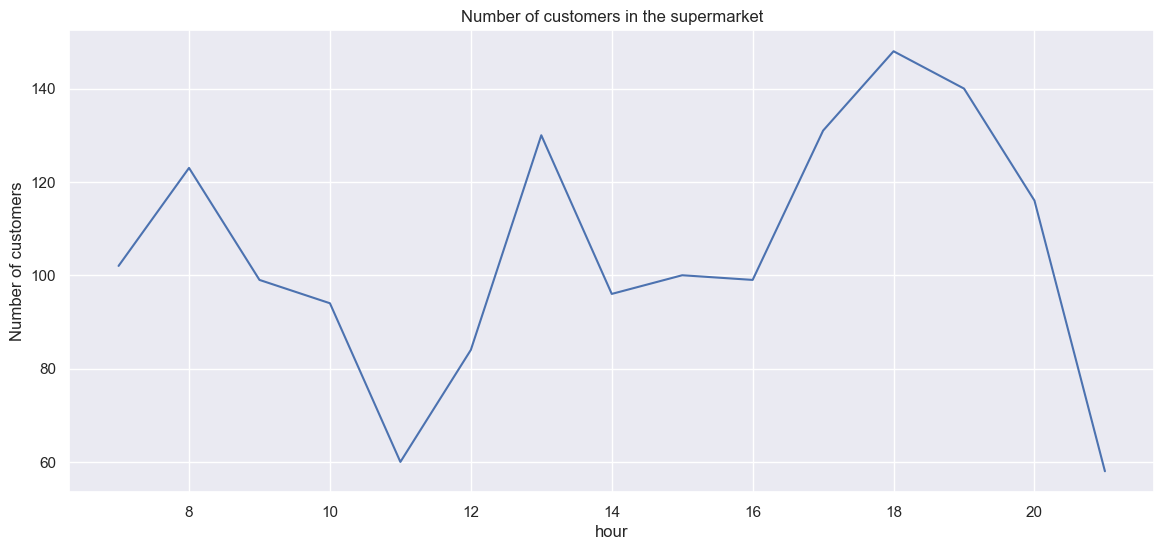

In [122]:
mondf.groupby(mondf.index.hour)['customer_no'].nunique().plot();
plt.title('Number of customers in the supermarket');
plt.xlabel('hour');
plt.ylabel('Number of customers');

**Let's plot the number of customers in all areas during every hour of the opening hours.**

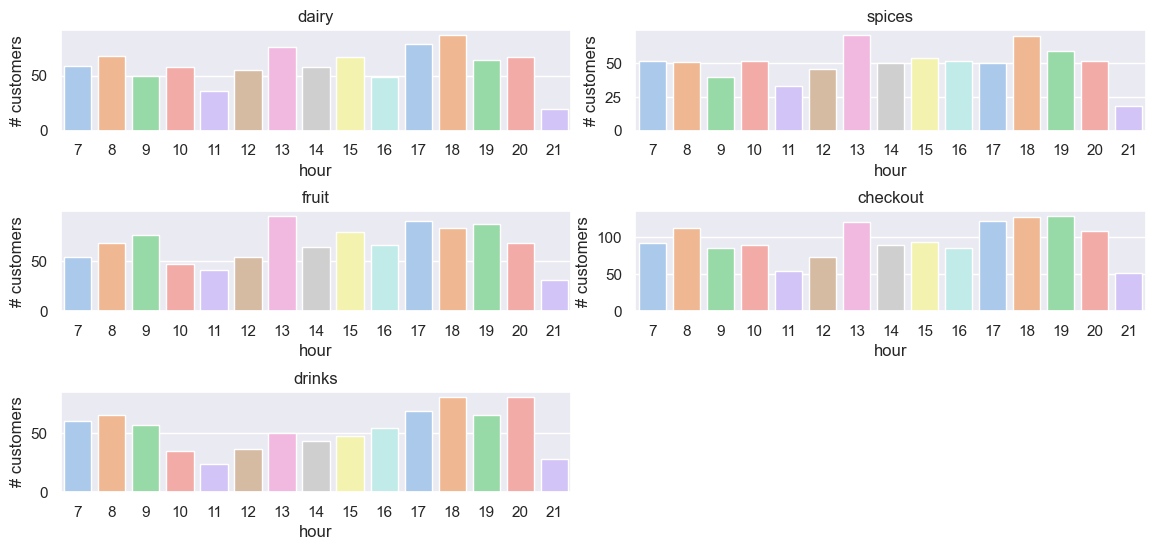

In [100]:
for idx, loc in enumerate(locations):
    plt.subplot(3, 2, idx+1)
    plt.subplots_adjust(hspace=0.8, wspace=0.125)
    ax=sns.countplot(data=mondf[mondf['location']==loc], x=mondf[mondf['location']==loc].index.hour, palette='pastel')
    ax.set(xlabel='hour', ylabel='# customers', title=(loc))

## Now let's engineer the data

To simulate area transitions, insert new column and indicate the area in which the customer will move after leaving the current location. Whenever a customer is located at checkout, s/he cannot move to another location, but will stay at checkout, indicating that s/he leaves the supermarket. 

Note that not every minute of a customer's stay in the supermarket is tracked. Instead, whenever the customer does not change the location, the respective minute is not tracked. This issue will be tackled in what follows.

In [8]:
mondf['after'] = mondf.groupby('customer_no')['location'].shift(-1).replace(np.nan,'checkout')

In [9]:
mondf.head(10)

,customer_no,location,after
timestamp,,,
2019-09-02 07:03:00,1,dairy,checkout
2019-09-02 07:03:00,2,dairy,checkout
2019-09-02 07:04:00,3,dairy,checkout
2019-09-02 07:04:00,4,dairy,checkout
2019-09-02 07:04:00,5,spices,checkout
2019-09-02 07:04:00,6,spices,dairy
2019-09-02 07:04:00,7,spices,drinks
2019-09-02 07:04:00,8,fruit,checkout
2019-09-02 07:05:00,1,checkout,checkout


**Get preliminary transition probability matrix for Markov Simulation**

Note that this matrix does not include the probabilty of transition to the same location, that is staying in the same location for a longer time (e.g., several minutes).

In [10]:
pd.crosstab(mondf['location'], mondf['after'])

after,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,1437,0,0,0,0
dairy,314,0,218,180,183
drinks,426,23,0,186,162
fruit,528,225,130,0,122
spices,179,235,217,119,0


**Aquire information on when customer leaves location**

The aim is to get the information on how long each customer stays in every location.

In [11]:
mondf.reset_index(inplace=True)
mondf['timestamp_leave'] = mondf.groupby('customer_no')['timestamp'].shift(-1) 

In [12]:
#assume that every customer spends 2 minutes at checkout
mondf['timestamp_leave'] = mondf['timestamp_leave'].fillna((mondf['timestamp']+timedelta(minutes=2)))

In [13]:
mondf.head(10)

,timestamp,customer_no,location,after,timestamp_leave
0,2019-09-02 07:03:00,1,dairy,checkout,2019-09-02 07:05:00
1,2019-09-02 07:03:00,2,dairy,checkout,2019-09-02 07:06:00
2,2019-09-02 07:04:00,3,dairy,checkout,2019-09-02 07:06:00
3,2019-09-02 07:04:00,4,dairy,checkout,2019-09-02 07:08:00
4,2019-09-02 07:04:00,5,spices,checkout,2019-09-02 07:05:00
5,2019-09-02 07:04:00,6,spices,dairy,2019-09-02 07:05:00
6,2019-09-02 07:04:00,7,spices,drinks,2019-09-02 07:05:00
7,2019-09-02 07:04:00,8,fruit,checkout,2019-09-02 07:07:00
8,2019-09-02 07:05:00,1,checkout,checkout,2019-09-02 07:07:00
9,2019-09-02 07:05:00,5,checkout,checkout,2019-09-02 07:07:00


In [14]:
#reset index to timestamp
mondf.set_index('timestamp',inplace=True)

In [15]:
mondf.head()

,customer_no,location,after,timestamp_leave
timestamp,,,,
2019-09-02 07:03:00,1,dairy,checkout,2019-09-02 07:05:00
2019-09-02 07:03:00,2,dairy,checkout,2019-09-02 07:06:00
2019-09-02 07:04:00,3,dairy,checkout,2019-09-02 07:06:00
2019-09-02 07:04:00,4,dairy,checkout,2019-09-02 07:08:00
2019-09-02 07:04:00,5,spices,checkout,2019-09-02 07:05:00


**Delete cases where only one location is visited.**

The reason is that people who enter the supermarket right before closing time, never reach checkout according to the dataframe. Therefore, we drop the respective entries (after inspecting the number of customers for whom that applies). 

In [21]:
#get overview of number of locations each customer visits during his/her stay
vis_areas = pd.DataFrame(mondf.groupby('customer_no')['location'].count())

In [18]:
vis_areas.head()

,location
customer_no,
1,2
2,2
3,2
4,2
5,2


In [19]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

In [20]:
#get customer numbers of those who never reach checkout
idx_list=[]
for l in range(vis_areas[vis_areas['location']==1].shape[0]):
    idx_list.append(vis_areas[vis_areas['location']==1].index[l])
print(idx_list)

[1439, 1445, 1446, 1447]


In [22]:
#remove above filtered customer ids
mondf = filter_rows_by_values(mondf, 'customer_no', idx_list)

**Use upsampling to get every minute in the timeframe**

To implement the Markov simulation, we need information on every minute of a customer's stay in the supermarket, including the information wheather a customer stays in the same location or moves to another one. Therefore, we extend the dataframe such that every minute of a customer's stay is tracked.

In [23]:
mondfres = mondf.groupby('customer_no',as_index=False).resample('1min').ffill()
mondfres.reset_index(inplace=True)
mondfres.drop(columns=['level_0'],inplace=True)
mondfres['time'] = mondfres['timestamp'].dt.time

In [24]:
mondfres['after'] = mondfres.groupby('customer_no')['location'].shift(-1)
mondfres['after'] = mondfres['after'].replace(np.nan,'checkout')

In [25]:
mondfres.head(10)

,timestamp,customer_no,location,after,timestamp_leave,time
0,2019-09-02 07:03:00,1,dairy,dairy,2019-09-02 07:05:00,07:03:00
1,2019-09-02 07:04:00,1,dairy,checkout,2019-09-02 07:05:00,07:04:00
2,2019-09-02 07:05:00,1,checkout,checkout,2019-09-02 07:07:00,07:05:00
3,2019-09-02 07:03:00,2,dairy,dairy,2019-09-02 07:06:00,07:03:00
4,2019-09-02 07:04:00,2,dairy,dairy,2019-09-02 07:06:00,07:04:00
5,2019-09-02 07:05:00,2,dairy,checkout,2019-09-02 07:06:00,07:05:00
6,2019-09-02 07:06:00,2,checkout,checkout,2019-09-02 07:08:00,07:06:00
7,2019-09-02 07:04:00,3,dairy,dairy,2019-09-02 07:06:00,07:04:00
8,2019-09-02 07:05:00,3,dairy,checkout,2019-09-02 07:06:00,07:05:00
9,2019-09-02 07:06:00,3,checkout,checkout,2019-09-02 07:08:00,07:06:00


**Get final transition probability matrix**

Includes now the probability for every customer to stay in current location.

In [26]:
pd.crosstab(mondfres['location'], mondfres['after'])

after,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,1437,0,0,0,0
dairy,312,2600,218,180,183
drinks,426,23,1250,186,162
fruit,526,225,130,1553,122
spices,179,235,217,119,478


In [27]:
#Normalize transition matrix in order to get probabilites for stay/change behaviour of customer.
trans_prob = pd.crosstab(mondfres['location'], mondfres['after'], normalize=0)

In [28]:
trans_prob

after,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.089322,0.744346,0.062411,0.051532,0.052390
drinks,0.208109,0.011236,0.610650,0.090865,0.079140
fruit,0.205790,0.088028,0.050861,0.607590,0.047731
spices,0.145765,0.191368,0.176710,0.096906,0.389251


# 2) Create Customer Class
In order to model a customer's behaviour in the super market efficiently and extend it to several customers, we define a customer class.



## Skeleton Code 

In [23]:
class Customer():
    """
    A class to model customer movement in the doodl supermarket via MCMC simulation
    """
    def __init__(self, cust_no=9999):
        self.customer_no = cust_no
        
    def __repr__(self):
        return f"Customer with the customer number {self.customer_no}"
    
    def change_location(self):
        print('Change loc placeholder')

**Let's check whether everything worked**

In [24]:
cust1 = Customer()
cust2 = Customer(300)
print(cust1.customer_no) #prints default customer number
print(cust2.customer_no) #prints customer number I attached to it

9999
300


In [25]:
print(cust1)
print(cust2)

Customer with the customer number 9999
Customer with the customer number 300


In [26]:
print(cust1.change_location())
print(cust2.change_location())

Change loc placeholder
None
Change loc placeholder
None


## Set up Customer Class

In [29]:
class Customer():
    """
    A class to model customer movement in the supermarket via MCMC simulation
    """
    
    def __init__(self, name='random customer', location='entry', budget=100):
        self.cust_name=name
        self.cust_location=location
        self.cust_budget=budget
        self.active=True
        
    def __repr__(self):
        return f"Customer with the customer id {self.cust_name}, located at {self.cust_location} with a budget of {self.cust_budget}"
    
    def is_active(self):
        """
        Returns True if customer has not reached checkout yet
        """
        if self.cust_location!='checkout':
            return True
        else: 
            return False
    
    def change_location(self,transition_probs):
        """
        Propagates the customer to next loaction. 
        Returns nothing.
        """
        if self.cust_location=='entry':
            self.cust_location=random.choices(['dairy', 'drinks', 'fruit', 'spices'])[0]
            return f"Customer {self.cust_name} just moved from entry area to the location {self.cust_location}."
        elif self.cust_location=='checkout':
            self.is_active()
            return f"Customer {self.cust_name} arrived checkout and thus is now turned inactive."
        else: 
            self.cust_location= random.choices(['checkout','dairy','drinks','fruit','spices'], np.array(transition_probs.loc[self.cust_location,:]))[0]
            return f"Customer {self.cust_name} just moved to the location {self.cust_location}."


# 3) Create Supermarket Class

In order to model multiple customers' behaviours in the supermarket, we additionally set up a supermarket class. 

In [40]:
class Supermarket:
    """
    Manages multiple Customer instances that are currently in the market.
    """

    def __init__(self):        
        self.customers = []
        self.minutes = 0
        self.last_id = 0
        self.num_exit = 0
        self.time = pd.to_datetime('07:00')
        self.df = pd.DataFrame({'timestamp': [], 'customer_id': [], 'location': []})

    def __repr__(self):
        return f'This is a simulation of a supermarket which has ran for {self.minutes} minutes and up to now, there have been {self.last_id} customers in the shop'

    def get_time(self):
        """
        Current time in HH:MM format,
        """
        return f"The current time at the supermarket is {(self.time + timedelta(minutes=self.minutes)).time()}. The supermarket has been open for {self.minutes} minutes."

    def present_simulation(self):
        """
        Print all customers with the current time and id to output.
        """
        supermarket_df = self.df
        print(f"""
        Here we go, let's have a look at our customer's behaviour in the Supermarket simulation!
        In total, the supermarket has been visited by {self.last_id} customers and was open for {self.minutes} minutes - from {self.df.iloc[0,0]} to {self.df.iloc[-1,0]}.
        Now, let's consider every customer's behaviour:
        """)
        for cust_id in range(self.last_id):
            time_spent=get_time_spent(cust_id,supermarket_df)
            number_of_areas=get_number_of_areas(cust_id, supermarket_df)
            print(f"""
            Let's have a look at the supermarket behaviour of customer {cust_id}:
            First, he spent {time_spent} minutes in the supermarket!
            In total, he visited {number_of_areas} different areas of the supermarket so far, that is the areas {get_areas_visited(cust_id,supermarket.df)}. 
            """)
        print(f""" 
        Nice! This output has been generated based on the following dataframe:
        """)
        print(self.df)

    def next_minute(self,trans_prob):
        """
        propagates all customers to the next state. writes data to dataframe. 
        """
        for cust in self.customers:
            cust.change_location(trans_prob)
            self.df = pd.concat([self.df, pd.DataFrame({'timestamp': [(self.time + timedelta(minutes=self.minutes)).time()], 'customer_id': [int(cust.cust_name)], 'location': [cust.cust_location]})], ignore_index=True)  
            if not cust.is_active():
                self.customers.remove(cust)
                self.num_exit+=1
        self.minutes+=1
        return f"The supermarket has been open for {self.minutes} minutes now."
    
    def add_new_customers(self,last_id):
        """
        randomly creates new customers.
        """
        new_cust=Customer(name=str(last_id), location='entry', budget=100)
        self.customers.append(new_cust)
        self.last_id+=1
        return f"Customer {new_cust} has entered the Supermarket. Now there are {len(self.customers)} customers in the supermarket."

    def remove_exiting_customers(self):
        """
        removes every customer that is not active any more.
        """
        num_exit=0
        for cust in self.customers:
            if not cust.is_active():
                self.customers.remove(cust)
                num_exit+=1
        return f"{num_exit} customers have exited the supermarket."

# 4) Define useful functions for simulation

In [41]:
def get_time_spent(cust_id, supermarket_df):
    """
    Get information on how many minutes a customer spent in the supermarket.
    """
    entry=supermarket_df[supermarket_df['customer_id']==(cust_id)].iloc[0,0]
    exitt=supermarket_df[supermarket_df['customer_id']==(cust_id)].iloc[-1,0]
    entry=pd.to_datetime(entry, format='%H:%M:%S')
    exitt=pd.to_datetime(exitt, format='%H:%M:%S')
    time_spent=(exitt-entry)/pd.Timedelta(minutes=1) 
    return time_spent

In [42]:
def get_number_of_areas(cust_id, supermarket_df):
    """
    Returns the number of different areas a customer visited during his/her stay in the supermarket.
    """
    numb_of_areas = pd.DataFrame(supermarket_df.groupby(['customer_id'])['location'].nunique()).iloc[int(cust_id),0]
    return numb_of_areas

In [43]:
def get_areas_visited(cust_id, supermarket_df):
    """
    Returns list of different areas a customer visited during his/her stay in the supermarket.
    """
    areas=supermarket.df.groupby(['customer_id'])['location'].unique()[cust_id]    
    return areas

In [44]:
def simulate_supermarket(trans_prob, minutes=10, max_number_of_custs=10):
    """
    Simulates supermarket based on a given transition probability matrix "trans_prob". The supermarket is simulated 
    for 10 minutes by default based on "minutes", and the maximum number of entering customers "max_number_of_custs" is 10.
    The entry time for each customer is randomly chosen within the time range the supermarket is open. Only one customer enters
    at a time. The supermarket opens at 10:00 a.m.. 
    """
    S = Supermarket()
    entry_minutes = random.sample(range(minutes),random.choices([*range(1,max_number_of_custs)])[0])
    for minute in range(minutes):
        if minute in entry_minutes:
            S.add_new_customers(S.last_id)
        S.next_minute(trans_prob)        
    return S

# 5) Go for simulations! 

We simulate a supermarket that is open for 30 minutes, with a maximum of 10 customers entering in that 30 minutes. The simulation is based on the transition probability matrix that we set up based on the data we got for our exemplary supermarket, saved in the dataframe *mondf*.

In [46]:
supermarket = simulate_supermarket(trans_prob, minutes=30, max_number_of_custs=10)

In [47]:
supermarket.present_simulation()


        Here we go, let's have a look at our customer's behaviour in the Supermarket simulation!
        In total, the supermarket has been visited by 9 customers and was open for 30 minutes - from 07:05:00 to 07:29:00.
        Now, let's consider every customer's behaviour:
        

            Let's have a look at the supermarket behaviour of customer 0:
            First, he spent 2.0 minutes in the supermarket!
            In total, he visited 2 different areas of the supermarket so far, that is the areas ['dairy' 'checkout']. 
            

            Let's have a look at the supermarket behaviour of customer 1:
            First, he spent 1.0 minutes in the supermarket!
            In total, he visited 2 different areas of the supermarket so far, that is the areas ['dairy' 'checkout']. 
            

            Let's have a look at the supermarket behaviour of customer 2:
            First, he spent 1.0 minutes in the supermarket!
            In total, he visited 2 different 

Let's have a look at the simulation's dataframe, which is of the same format as our inital dataframe *mondf*.

In [48]:
supermarket.df

,timestamp,customer_id,location
0,07:05:00,0.0,dairy
1,07:06:00,0.0,dairy
2,07:07:00,0.0,checkout
3,07:08:00,1.0,dairy
4,07:09:00,1.0,checkout
5,07:10:00,2.0,drinks
6,07:11:00,2.0,checkout
7,07:12:00,3.0,dairy
8,07:13:00,3.0,dairy
9,07:13:00,4.0,drinks
